In [28]:
# Core Libraries
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

# Stable-baselines3 (for later phases)
from stable_baselines3 import DQN, PPO

# Optional logging
import wandb

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [73]:
# Create LunarLander environment
env = gym.make("LunarLander-v3", render_mode='rgb_array')  # 'rgb_array' allows saving frames
# env = gym.make("LunarLander-v3", render_mode='human')  # 'rgb_array' allows saving frames

# Print state and action space
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)


State shape:  (8,)
State size:  8
Number of actions:  4


## Implement a Random Agent

In [17]:
num_episodes = 100
total_rewards = []
episode_lengths = []

for episode in range(num_episodes):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    step_count = 0

    while not done:
        action = env.action_space.sample()  # Random action
        obs, reward, done, _, info = env.step(action)
        episode_reward += reward
        step_count += 1

    total_rewards.append(episode_reward)
    episode_lengths.append(step_count)

env.close()

### Metrics for Random Agent

In [21]:
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)
min_reward = np.min(total_rewards)
max_reward = np.max(total_rewards)
mean_length = np.mean(episode_lengths)
std_length = np.std(episode_lengths)

print(f"Random Agent Reward Metrics over {num_episodes} episodes:")
print(f"Mean: {mean_reward:.2f}, Std: {std_reward:.2f}, Min: {min_reward:.2f}, Max: {max_reward:.2f}")
print(f"Average Episode Length: {mean_length:.2f}, Std: {std_length:.2f}")

Random Agent Reward Metrics over 100 episodes:
Mean: -176.96, Std: 117.28, Min: -507.47, Max: 54.97
Average Episode Length: 91.60, Std: 20.48


### Plot Reward Distribution and Episode Length Distribution

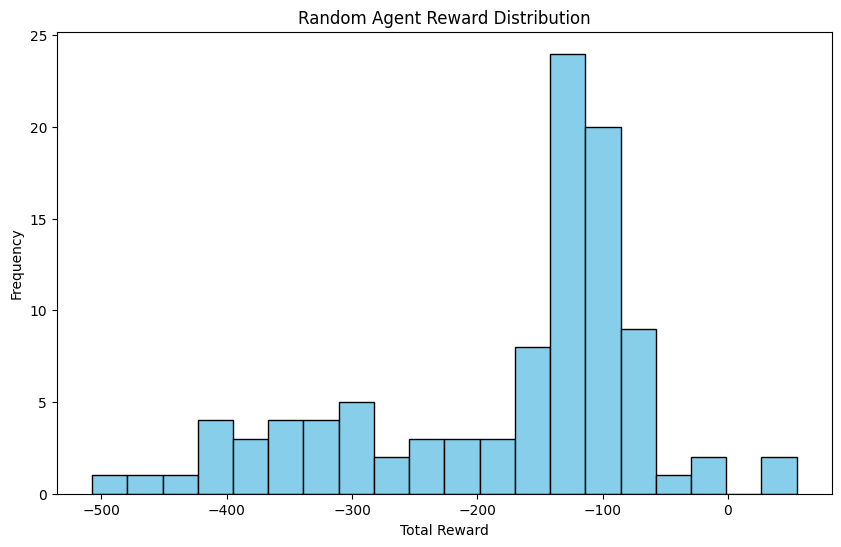

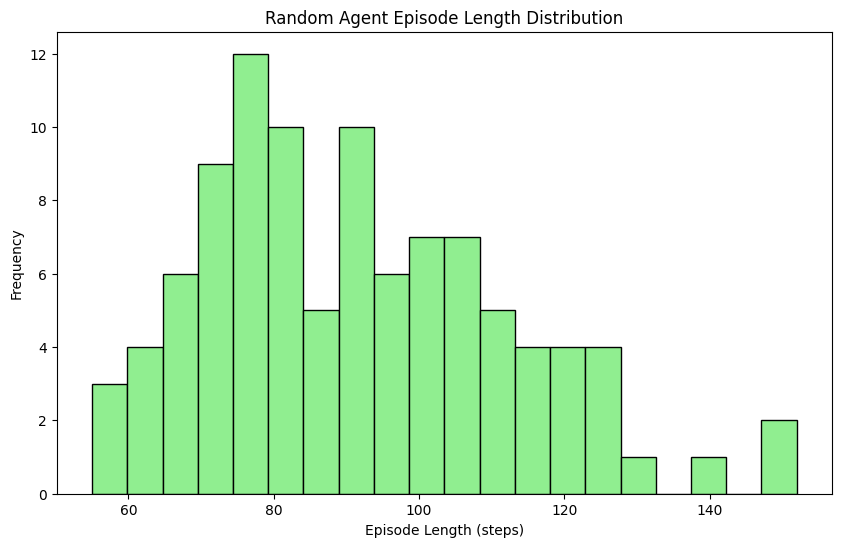

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(total_rewards, bins=20, color='skyblue', edgecolor='black')
plt.title("Random Agent Reward Distribution")
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(episode_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.title("Random Agent Episode Length Distribution")
plt.xlabel("Episode Length (steps)")
plt.ylabel("Frequency")
plt.show()

# Deep Q Network

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple
import gymnasium as gym


env = gym.make('LunarLander-v3') # The Lunar Lander environment was upgraded to v3
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


In [104]:
learning_rate = 5e-4
minibatch_size = 100
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

## DQN Network Definition


In [105]:
class DQNetwork(nn.Module):

  def __init__(self, state_size, action_size, seed = 42):
    super(DQNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)

  def forward(self, state):
    x = self.fc1(state)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    return self.fc3(x)

## Replay Memory Implementation

In [106]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity = capacity
    self.memory = []

  def push(self, event):
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      del self.memory[0]

  def sample(self, batch_size):
    experiences = random.sample(self.memory, k = batch_size)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones

## DQN Agent Implementation

In [107]:
class Agent():

  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    self.local_qnetwork = DQNetwork(state_size, action_size).to(self.device)
    self.target_qnetwork = DQNetwork(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.push((state, action, reward, next_state, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(100)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(list(np.arange(self.action_size)))


  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

In [108]:
agent = Agent(state_size, number_actions)

## Training

In [110]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

Episode 100	Average Score: -100.25
Episode 200	Average Score: -13.433
Episode 300	Average Score: 91.767
Episode 383	Average Score: 200.57
Environment solved in 283 episodes!	Average Score: 200.57


## Save GIF for a DQN episode 

In [115]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
import gymnasium as gym

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    env.close()

    frames = [np.array(f, dtype=np.uint8) for f in frames]

    imageio.mimsave('dqn_lunar.gif', frames, fps=30)



show_video_of_model(agent, 'LunarLander-v3')